`firefly/ntbks/flask_tutorial.ipynb`

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import IFrame,YouTubeVideo

A recording of this jupyter notebook in action is available at:

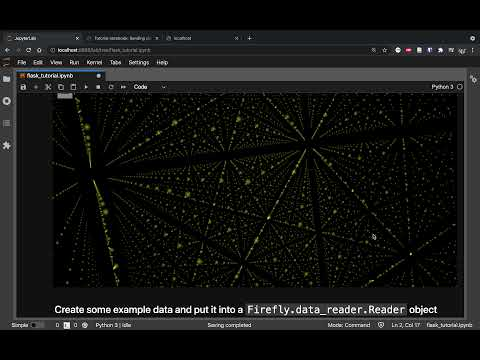

In [2]:
YouTubeVideo("OD598z7pqB0")

In [3]:
import numpy as np
import os

import requests


import sys
sys.path.insert(0, '/Users/ageller/VISUALIZATIONS/Firefly')
sys.path.insert(0,'/Users/agurvich/research/repos/firefly/src')
from firefly.data_reader import ArrayReader
from firefly.server import spawnFireflyServer,killAllFireflyServers

# Tutorial notebook: Sending data to a local Firefly server through Flask
A drawback of using `.json` files on disk to pass data between the Python frontend and the Firefly webapp is that these `.json` files can 
1. take up a lot of unnecessary disk space 
2. take a long time to read from disk

To address these problems, we use Flask to host a webserver and parse data directly from Python at a data upload endpoint. This procedure is detailed in the <a href="https://ageller.github.io/Firefly/docs/build/html/server/index.html">server documentation</a>. From the user's perspective, all they need to do is POST their data to a specific port on their local machine and they will be able to explore their own data without ever having to write a file to disk. 

## Start the Firefly server as a background process
In this tutorial we'll demonstrate how to update the data being shown in a live instance of Firefly running on a local webserver through Flask. Before attempting this tutorial read through the <a href="https://ageller.github.io/Firefly/docs/build/html/server/index.html">server documentation</a> which explains how to specify the listening port and different methods of hosting a Flask Firefly server (here we use the `firefly.server.spawnFireflyServer` function which starts a background process).

In [4]:
process = spawnFireflyServer()

Waiting up to 10 seconds for background Firefly server to start...done! Your server is available at - http://localhost:5000


## Show Firefly in an IFrame
IPython allows one to embed webpages into a notebook using an IFrame, we'll take advantage of that to embed Firefly here (you can also visit the localhost:5000 url in your browser if you'd prefer). 

In [5]:
url = "http://localhost:5000"
IFrame(url, width=1000, height=500)

## Create some example data and put it into a `firefly.data_reader.Reader` object
See the <a href="https://ageller.github.io/Firefly/docs/build/html/data_reader/reader.html">reader documentation</a> or the `reader_tutorial.ipynb` example notebook. 

In [6]:
## let's create some sample data, a grid of points in a 3d cube
my_coords = np.linspace(-10,10,20)
xs,ys,zs = np.meshgrid(my_coords,my_coords,my_coords)
xs,ys,zs = xs.flatten(),ys.flatten(),zs.flatten()
coords = np.array([xs,ys,zs]).T

## we'll pick some random field values to demonstrate filtering/colormapping
fields = np.random.random(size=xs.size)

We'll use an `ArrayReader` here, check out the `reader_tutorial.ipynb` example notebook if this is new for you!

In [7]:
my_arrayReader = ArrayReader(
    coords,
    fields=fields,
    write_jsons_to_disk=False)

JSONdir is None, defaulting to /Users/agurvich/research/repos/firefly/src/firefly/static/data/Data
Make sure each tracked_array (1) has a tracked_filter_flag (0), assuming True.
Make sure each tracked_array (1) has a tracked_colormap_flag (0), assuming True.
Outputting: PGroup_0 - 8000/8000 particles - 1 tracked fields


## Send this data to the Flask app
The data will be sent to the Firefly server via a POST request, we can do this in python using the `requests` module. One the POST has been made scroll back up to the window above and see the new data (if you don't see new data, it's possible that you've overwritten the default `startup.json` that shipped with Firefly by following some of the other tutorials. That's okay! See the <a href="https://ageller.github.io/Firefly/docs/build/html/data_reader/multiple_datasets.html">multiple datasets documentation</a> or the `multiple_datasets.ipynb` example notebook to learn more about the `startup.json` file. 

In [8]:
## make a POST request to port 5000, supplying the JSON produced by setting 
##  write_jsons_to_disk=False and calling .dumpToJSON
port = 5000
print('sending to Firefly', sys.getsizeof(my_arrayReader.JSON))
requests.post(f'http://localhost:{port:d}/data_input',json=my_arrayReader.JSON)

sending to Firefly 425649


<Response [200]>

We've also wrapped this code in the `.sendDataViaFlask` method.

In [9]:
## make a POST request
my_arrayReader.sendDataViaFlask()

Posting...data posted!


## Killing the Firefly server process when you're done
Because the Firefly server was started in the background, the process will persist even when you're done with it. You should make sure to kill it using the `firefly.server.killAllFireflyServers` function. If you supply a process id (which is returned by the `spawnFireflyServer` function) then it will only kill that one process. However, processes are a bit defensive and sometimes we've found they survive the attempt on their life and then hide under a different PID. In which case, it's always safest to just kill all the servers indiscriminately. Generally the two are interchangeable unless you're hosting multiple local servers of Firefly on different ports. This is pretty uncommon/advanced in which case you hopefully know what you're doing. 

In [10]:
killAllFireflyServers()

15